In [ ]:
!cd .. && maturin build --release

In [ ]:
%pip install /home/ubuntu/omelette/target/wheels/rejoice-0.1.0-cp39-cp39-manylinux_2_27_x86_64.whl --force-reinstall

In [4]:
import sys
sys.path.append('..')
import importlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from tbparse import SummaryReader
import pandas as pd
import numpy as np
import seaborn as sns
from natsort import natsorted
import matplotlib.pyplot as plt
import networkx as nx
import os
from itertools import groupby
from collections import namedtuple
import math
import time
from PropLang import PropLang
from MathLang import MathLang
import rejoice
from rejoice import EGraph
from rejoice.lib import Language
from rejoice.pretrain_dataset_gen import EGraphSolver
from os import listdir
from natsort import natsort_keygen

/home/ubuntu/anaconda3/envs/omelette/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-20 22:13:55.004981: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
# !sudo apt install --yes cm-super dvipng texlive-fonts-recommended texlive-latex-extra texlive-latex-recommended

In [55]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams['font.size'] = 18

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

# Limitations of Equality Saturation

In [ ]:
def run_egg(lang: Language, expr, node_limit=10_000, iter_limit=7):
    print(f"running egg for expr", expr)
    first_stamp = int(round(time.time() * 1000))
    egraph = EGraph()
    egraph.add(expr)
    stop_reason, num_applications, num_enodes, num_eclasses = egraph.run(lang.rewrite_rules(), iter_limit=iter_limit, node_limit=node_limit)
    print(stop_reason, "num_applications", num_applications, "num_enodes", num_enodes, "num_eclasses", num_eclasses)
    best_cost, best_expr = egraph.extract(expr)
    second_stamp = int(round(time.time() * 1000))
    # Calculate the time taken in milliseconds
    time_taken = second_stamp - first_stamp
    # egraph.graphviz("egg_best.png")
    print(f"egg best cost:", best_cost, "in",
            f"{time_taken}ms", "best expr: ", best_expr)
    return best_cost, best_expr, num_applications, num_enodes

In [ ]:
lang = MathLang()
ops = lang.all_operators_obj()
Add, Integral, Mul, Pow, Diff, Ln, Div, Cos, Sub, Sqrt = ops.add, ops.integral, ops.mul, ops.pow, ops.diff, ops.ln, ops.div, ops.cos, ops.sub, ops.sqrt
expr = ops.sub(ops.add(16, 2), 0)
best_cost, _, _, _ = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Minimum")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Optimum Reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Number of rules applied")
ax.set_ylabel("Node count")

plt.savefig("sync/egg_node_count_math.pdf", bbox_inches='tight')


In [ ]:
lang = PropLang()
ops = lang.all_operators_dict()
AND, NOT, OR, IM = ops["and"], ops["not"], ops["or"], ops["implies"]
x, y, z = "x", "y", "z"
expr = OR(AND(x, y), IM(x, z))
best_cost, _, _, _ = run_egg(lang, expr, 1_000, 7)
solver = EGraphSolver(lang=lang, expr=expr, node_limit=1_000)
steps = solver.optimize(max_steps=10000)
df = pd.DataFrame(steps)
df["label"] = "optimal"
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"

best_cost_ind = df2["cost"].eq(best_cost).idxmax()

df3 = df2.reset_index()
ax = sns.lineplot(data=df3, x="index", y="num_enodes", hue="label")
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.axvline(len(df), linestyle='--', color='green', label="Theoretical Minimum")
ax.axvline(best_cost_ind, linestyle=':', color='red', label="Optimum Reached")
leg = plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
leg.set_frame_on(False)
ax.set_xlabel("Number of rules applied")
ax.set_ylabel("Node count")

plt.savefig("sync/egg_node_count.pdf", bbox_inches='tight')


In [ ]:
solver2 = EGraphSolver(lang=lang, expr=expr, node_limit=10_000)
steps2 = solver2.egg_like(max_steps=100_000)
df2 = pd.DataFrame(steps2)
df2["label"] = "egg"
df2["enodes_added"] = df2["num_enodes"].diff()
df2 = df2.groupby("action_name").agg('sum').reset_index()
df2 = df2[["action_name", "num_applications", "enodes_added"]]
df2 = df2.melt("action_name")
plt.rcParams['font.size'] = 18
plt.figure(figsize=(15, 5))
ax = sns.barplot(x="action_name", y="value", hue="variable", data=df2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
sns.despine(top=True, right=True)
ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15

ax.set_xlabel("Rewrite Rule")
ax.set_ylabel("Count")
plt.legend(bbox_to_anchor=(0.9, 1), loc='upper left', borderaxespad=0)
leg = ax.axes.get_legend()
leg.set_frame_on(False)

new_labels = ['Applications', 'Nodes added']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.savefig("sync/egg_limits_rules.pdf", bbox_inches='tight')

# Single-Task Performance

## Easy task

In [29]:
def smooth(scalars: list[float], weight=0.9) -> list[float]:  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
        
    return smoothed

In [ ]:
# Load log data
log_dir = "../ppo_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_training = df[df['dir_name'] == 'egraph-v0__ppo__1__1655144794']
df_prop["Lang"] = "PROP"
# TODO: change this
df_math = df[df['dir_name'] == 'egraph-v0__ppo__1__1655273840']
df_math["Lang"] = "MATH"

plang = PropLang()
psat_expr = plang.get_single_task_exprs().saturatable
psolver = EGraphSolver(lang=plang, expr=psat_expr)
p_best_cost, p_best_expr, p_num_applications, p_num_enodes = run_egg(plang, psat_expr)

mlang = MathLang()
msat_expr = mlang.get_single_task_exprs().saturatable
msolver = EGraphSolver(lang=mlang, expr=msat_expr)
m_best_cost, m_best_expr, m_num_applications, m_num_enodes = run_egg(mlang, msat_expr)

def smooth_tensorboard_plots(df):
    smoothed_return = smooth(df[df["tag"] == "charts/episodic_return"]["value"].tolist())
    smoothed_cost = smooth(df[df["tag"] == "charts/episodic_cost"]["value"].tolist())
    smoothed_length = smooth(df[df["tag"] == "charts/episodic_length"]["value"].tolist())
    df2 = pd.DataFrame({"Return": smoothed_return, "Cost": smoothed_cost, "Length": smoothed_length, "Lang": df.iloc[0]["Lang"]})
    return df2

def plot_single_task_easy_grid(df_prop, df_math):
    chart_list = ['charts/episodic_return', 'charts/episodic_cost', 'charts/episodic_length', 'charts/acc_rewrites']

    df_prop = df_prop.loc[df_prop['tag'].isin(chart_list)]
    df_math = df_math.loc[df_math['tag'].isin(chart_list)]

    df_prop = df_prop[df_prop["step"] < 130_000]
    df_math = df_math[df_math["step"] < 130_000]
    # find steps where episodic_cost is minimum
    # then get min of acc_rw of those rows
    # df_prop.groupby("step")
    df_prop_minlen = 7

    df_prop = smooth_tensorboard_plots(df_prop)
    df_math = smooth_tensorboard_plots(df_math)

    df_math_minlen = 4
    
    df_all = pd.concat([df_prop, df_math])

    df = pd.melt(df_all, id_vars=["Lang"], ignore_index=False)
    # plt.figure(figsize=(5, 10))
    g = sns.relplot(x=df.index, y="value", row="variable", col="Lang", kind="line", data=df, facet_kws={'sharey': False, 'sharex': False}, height=3, aspect=2.5/1)

    # g.set(xlabel="Episode")
    g.fig.subplots_adjust(wspace=.2, hspace=.1)
    ylabels = ["Episodic Return", "",
              "Episodic Cost", "",
              "Episodic Length", ""]

    for ind, ax in enumerate(g.axes.flatten()):
        if ind == 0:
            ax.set_title("PROP", pad=20, fontweight="bold")
        elif ind == 1:
            ax.set_title("MATH", pad=20, fontweight="bold")
        else:
            ax.set_title("")

        if ind not in [4, 5]:
            ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        ax.set_xlabel("")
        if ind in [4, 5]:
            ax.set_xlabel("Episode")

    # create separate barplot
    # Lang, num_applications_egg, num_applications_omelette
    data = [["PROP", p_num_applications, df_prop_minlen],
            ["MATH", m_num_applications, df_math_minlen]]
    df = pd.DataFrame(data, columns=["Lang", "Egg", "Omelette"])   
    df = df.melt(["Lang"])
    return g, df

g, bpdf = plot_single_task_easy_grid(df_prop, df_math)
g.fig.savefig("sync/single_task_easy.pdf", bbox_inches='tight')

In [ ]:
bp = sns.catplot(x="variable", y="value",
            col="Lang",
            kind="bar", data=bpdf, log=True)

bp.set_ylabels("Rule Applications (log)")

# iterate through axes
for ax in bp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height() / 1000):.1f}K' if v.get_height() > 100 else f'{v.get_height():2}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

titles = ["PROP", "MATH"]
for ind, ax in enumerate(bp.axes.flatten()):
    ax.yaxis.labelpad = 15
    ax.xaxis.labelpad = 15
    ax.set_xlabel("")
    ax.set_title(titles[ind], pad=20, fontweight="bold")

bp.savefig("sync/num_apps.pdf")


## Hard Task

In [79]:
log_dir = "../ppo_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'egraph-v0__PropLang_8__1__1655607444']

def smooth_tensorboard_plots(df, weight=0.9):
    smoothed_return = smooth(df[df["tag"] == "charts/episodic_return"]["value"].tolist(), weight=weight)
    smoothed_cost = smooth(df[df["tag"] == "charts/episodic_cost"]["value"].tolist(), weight=weight)
    smoothed_length = smooth(df[df["tag"] == "charts/episodic_length"]["value"].tolist(), weight=weight)
    df = pd.DataFrame({"Return": smoothed_return, "Cost": smoothed_cost, "Length": smoothed_length})
    return df

/tmp/ipykernel_22742/1442740324.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  step_data['total_apps'] = step_data.groupby('solver')['num_applications'].cumsum()


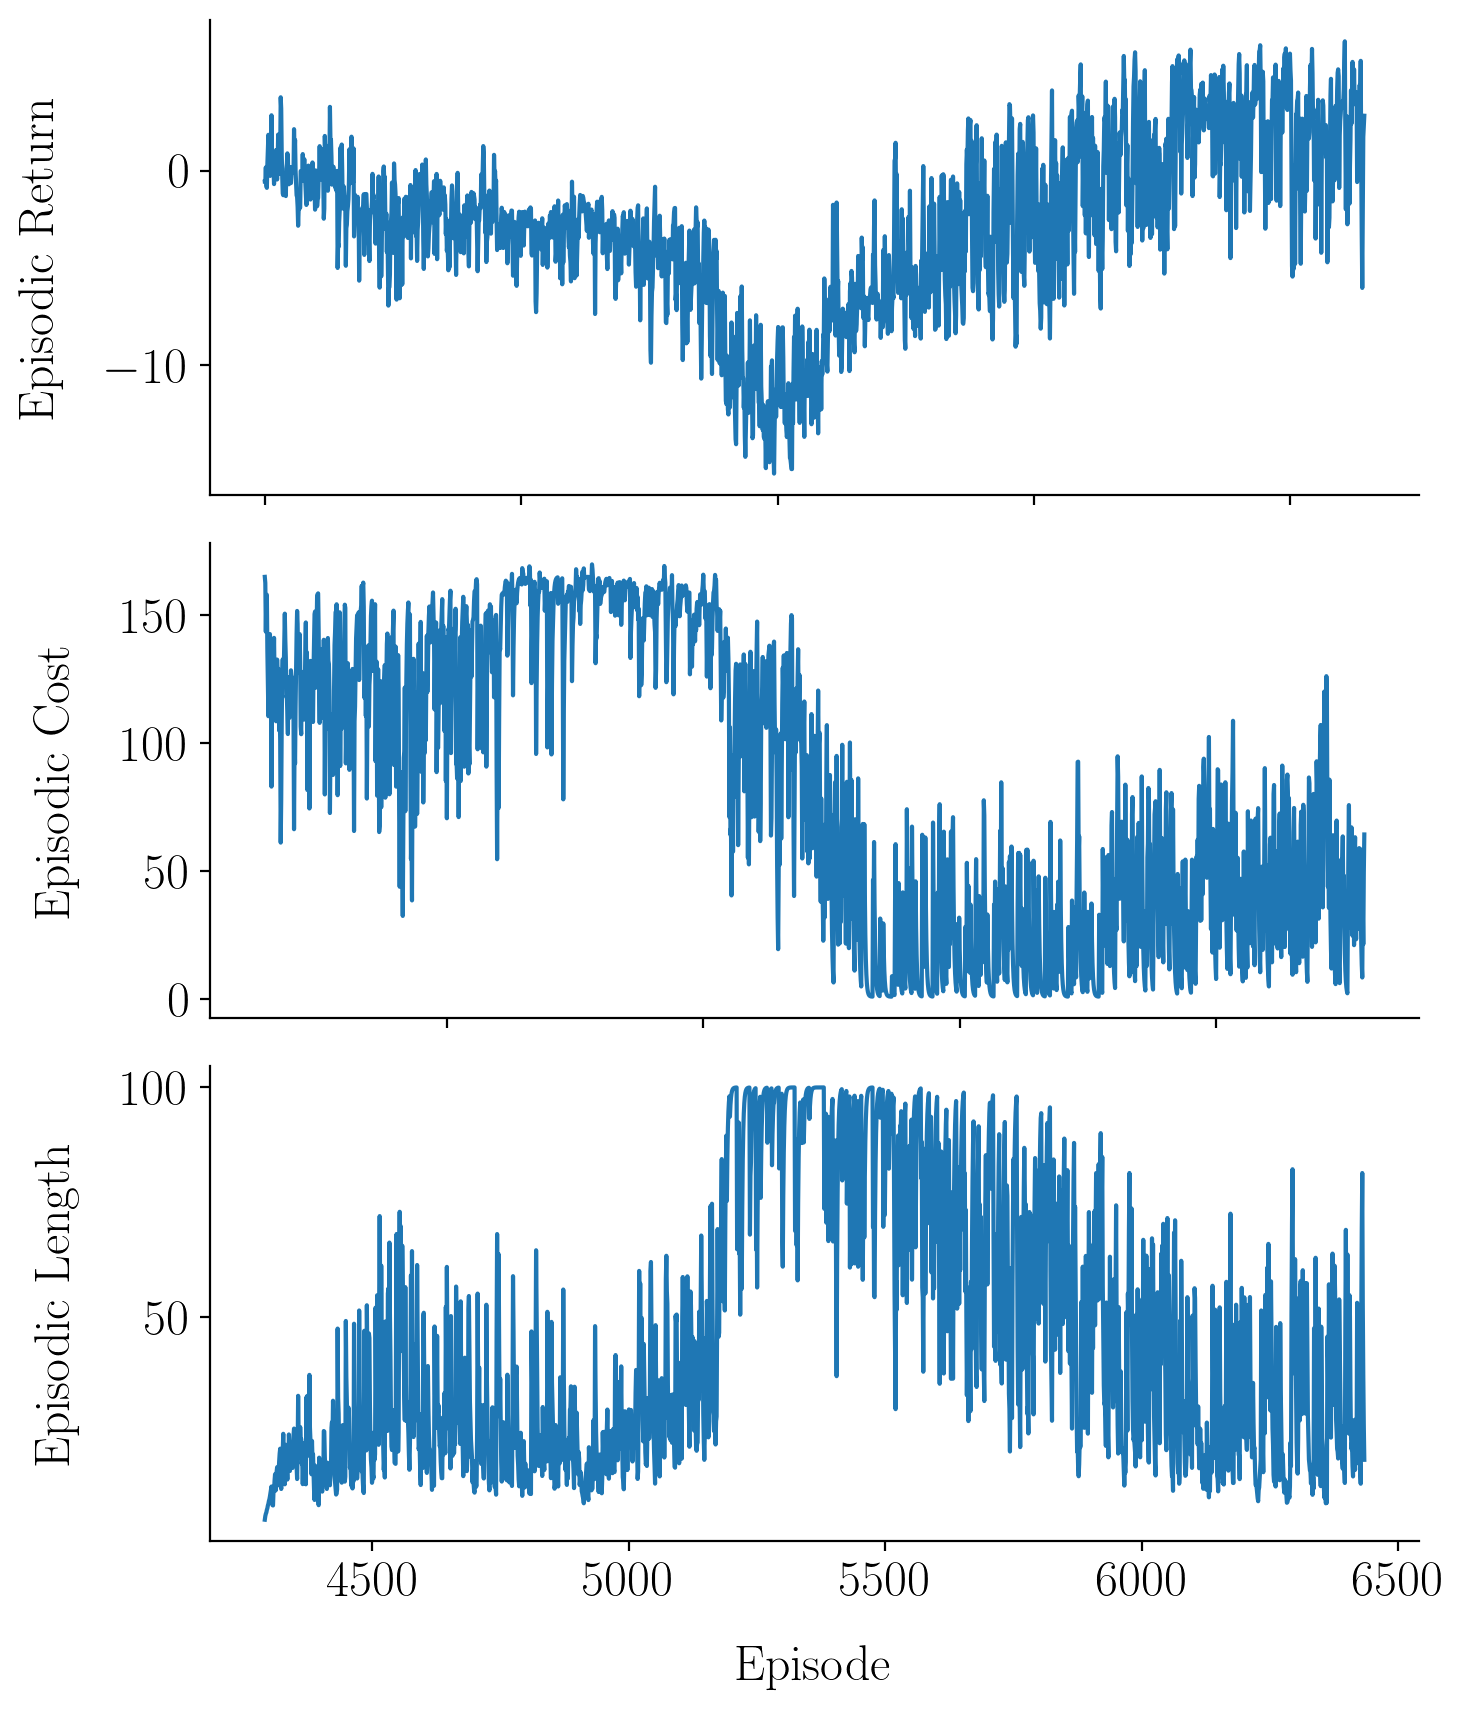

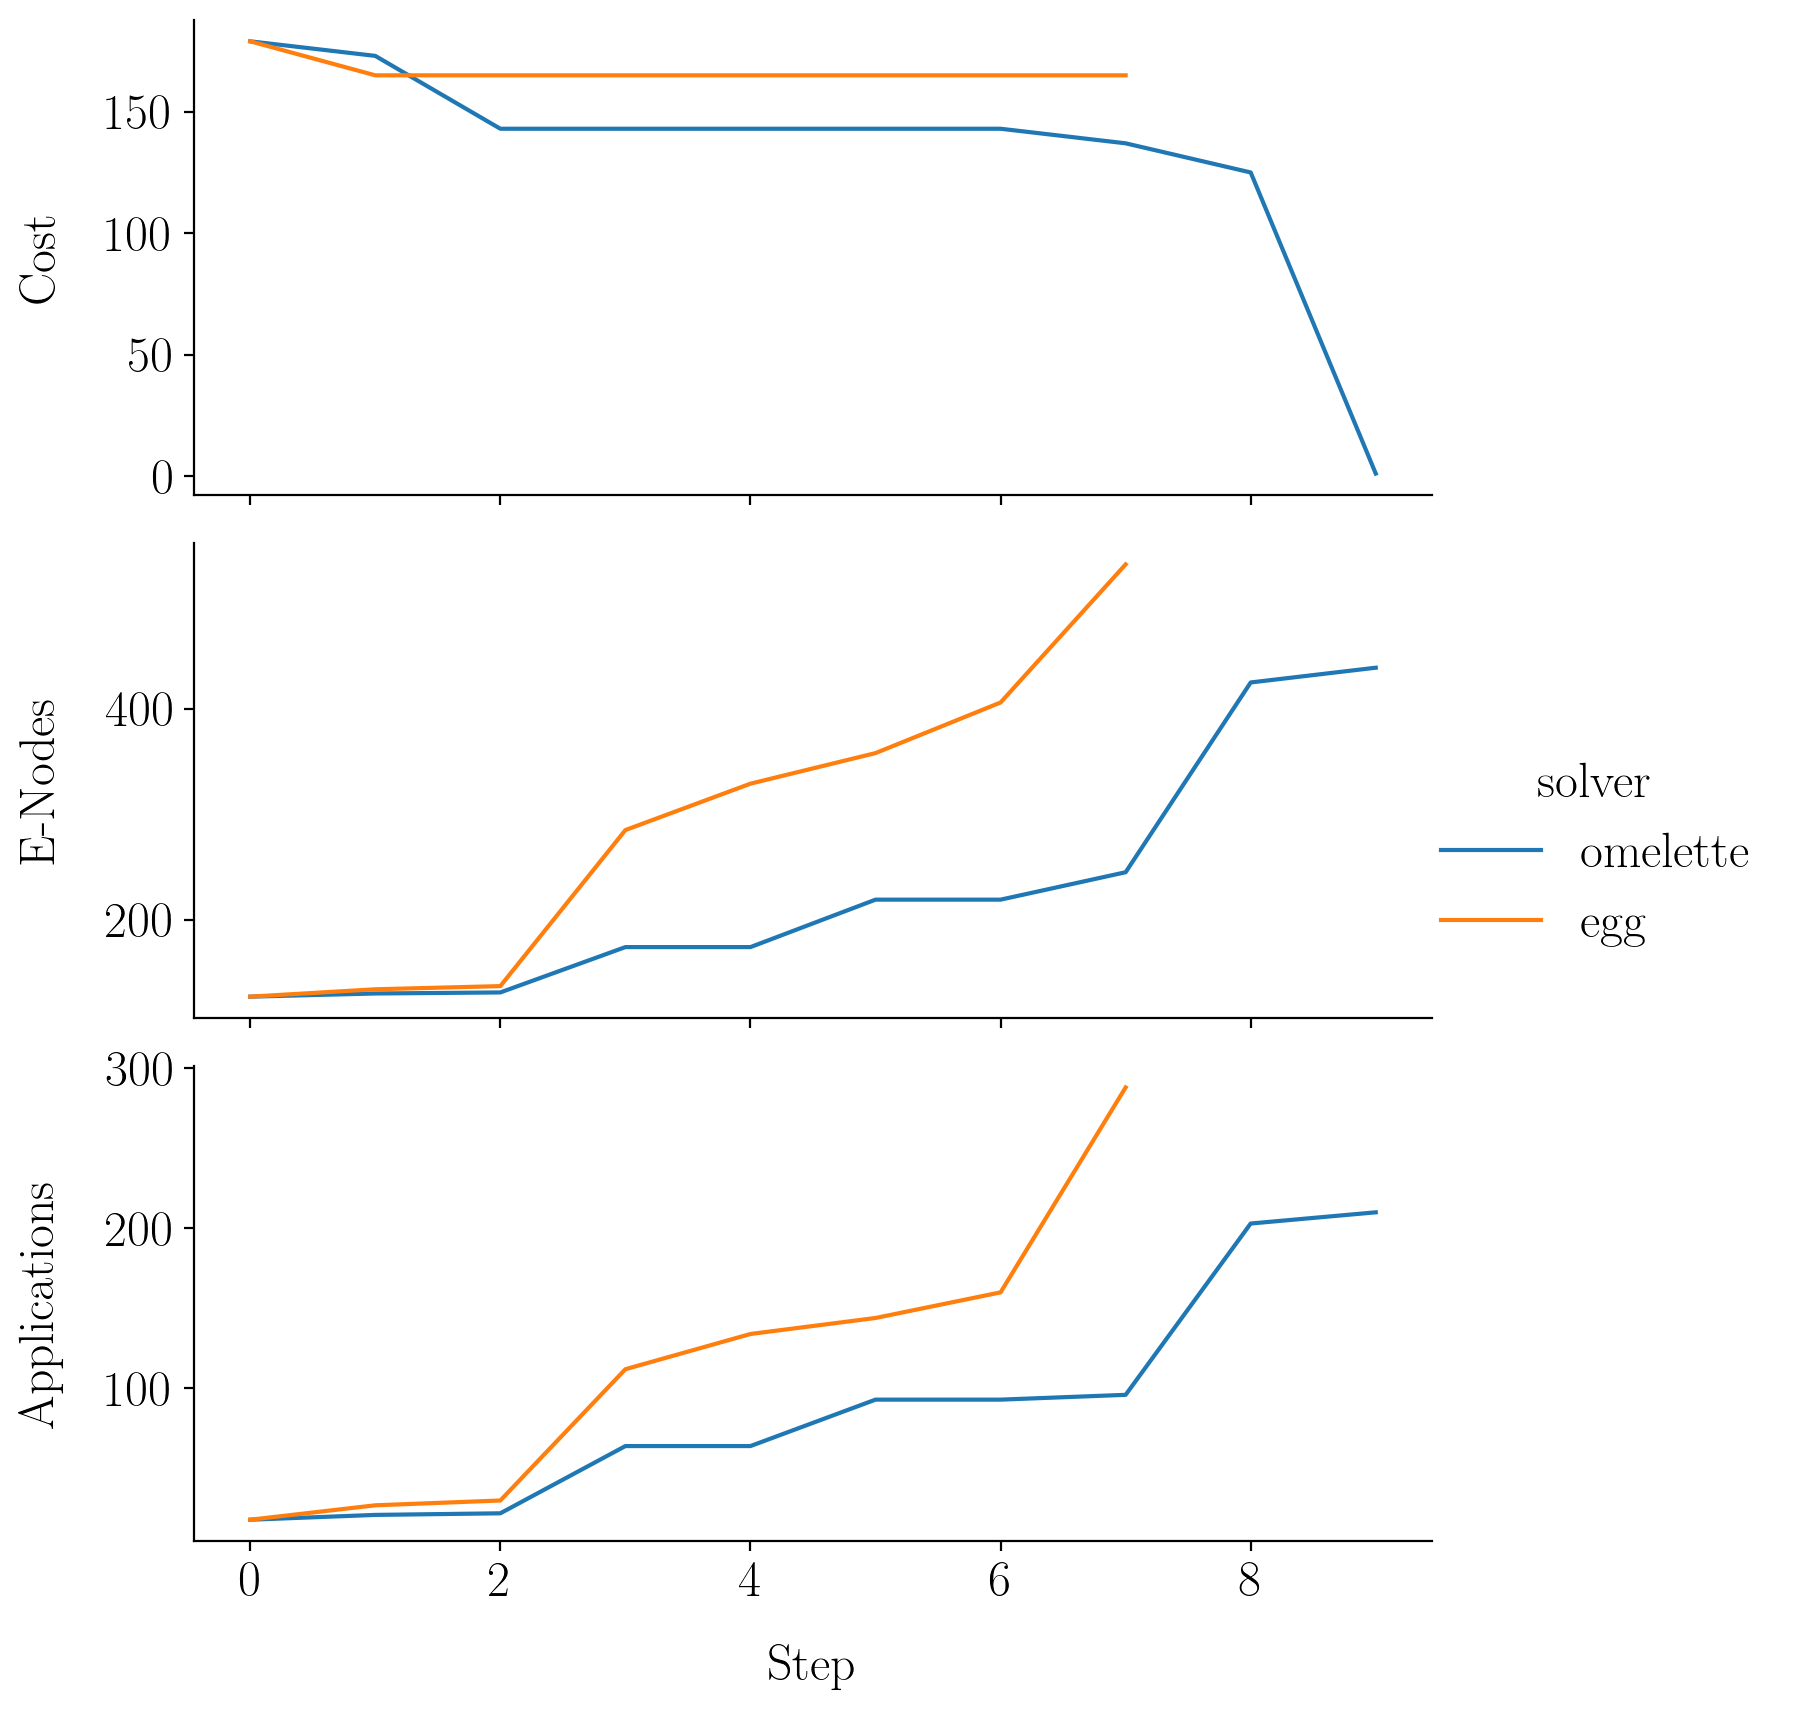

In [99]:

def plot_single_task_hard_grid(df_training, step_data):
    # get training curve data from tensorboard
    chart_list = ['charts/episodic_return', 'charts/episodic_cost', 'charts/episodic_length']
    df_training = df_training.loc[df_training['tag'].isin(chart_list)]
    df_training = smooth_tensorboard_plots(df_training, weight=0.6)
    df_training = df_training.melt()

    # get step data:
    # cost over steps (compared b/w this and egg)
    # accumulated rewrites over steps
    # node count over steps

    step_data = step_data[["solver", "step_ind", "cost", "num_enodes", "num_applications"]]
    step_data['total_apps'] = step_data.groupby('solver')['num_applications'].cumsum()
    step_data = step_data.drop(columns=["num_applications"])
    step_data = step_data.melt(["solver", "step_ind"])

    # fig, axes = plt.subplots(1, 2)

    g1 = sns.relplot(x=df_training.index, y="value", row="variable", kind="line", data=df_training, facet_kws={'sharey': False, 'sharex': False}, height=3, aspect=2.5/1)
    g1.fig.subplots_adjust(hspace=.1)
    ylabels = ["Episodic Return",
              "Episodic Cost",
              "Episodic Length"]

    for ind, ax in enumerate(g1.axes.flatten()):
        ax.set_title("")

        if ind < 2:
            ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        ax.set_xlabel("")
        if ind == 2:
            ax.set_xlabel("Episode")


    g2 = sns.relplot(x="step_ind", y="value", row="variable", hue="solver", kind="line", data=step_data, facet_kws={'sharey': False, 'sharex': True}, height=3, aspect=2.5/1)
    g2.fig.subplots_adjust(hspace=.1)
    ylabels = ["Cost",
              "E-Nodes",
              "Applications"]

    for ind, ax in enumerate(g2.axes.flatten()):
        ax.set_title("")

        # if ind < 2:
        #     ax.set(xticklabels=[])
    
        ax.set_ylabel(ylabels[ind])
        ax.yaxis.labelpad = 15
        ax.xaxis.labelpad = 15
        
        ax.set_xlabel("")
        if ind == 2:
            ax.set_xlabel("Step")

    return g1, g2

all_data = load_data()
step_data = all_data[all_data["expr_ind"] == '8'].set_index(["step_ind"]).reset_index()

g1, g2 = plot_single_task_hard_grid(df_prop, step_data)
g1.fig.savefig("sync/single_task_hard_training.pdf", bbox_inches='tight')
g2.fig.savefig("sync/single_task_hard_steps.pdf", bbox_inches='tight')

In [ ]:
all_data = load_data()
step_data = all_data[all_data["expr_ind"] == '1'].set_index(["step_ind"]).reset_index()

g1, g2 = plot_single_task_hard_grid(df_prop, step_data)
g1.fig.savefig("sync/single_task_hard_training.pdf", bbox_inches='tight')
g2.fig.savefig("sync/single_task_hard_steps.pdf", bbox_inches='tight')

# Pretraining Graphs

### PROP

##### Dataset analysis

In [3]:
def load_dataset(dataset_dir: str):
  files = os.listdir(dataset_dir)
  files.sort()
  keyf = lambda f: f.split("_")[0]

  files_grouped_by_expr = [list(expr_files) for gr, expr_files in groupby(files, key=keyf)]

  Row = namedtuple('Row', ['max_cost', 'min_cost', 'om_actions', 'egg_actions', 'action_mult', 'om_enodes', 'egg_enodes', 'enodes_mult', 'om_eclasses', 'egg_eclasses', 'eclasses_mult'])

  rows = []

  for group in files_grouped_by_expr:
    min_actions = len(group)
    # pick the last data object (the one from termination)
    d = torch.load(dataset_dir + "/" + group[-1])
    num_eclasses = int(torch.sum(d["x"][:, 0]).item())
    num_enodes = int(len(d["x"]) - num_eclasses)

    node_mult = (d.egg_enodes / num_enodes)
    class_mult = (d.egg_eclasses / num_eclasses)
    action_mult = (d.egg_rewrites / min_actions)

    rows.append(Row(max_cost=d.max_cost, min_cost=d.min_cost, om_actions=min_actions, egg_actions=d.egg_rewrites, action_mult=action_mult,
        om_enodes=num_enodes, egg_enodes=d.egg_enodes, enodes_mult=node_mult,
        om_eclasses=num_eclasses, egg_eclasses=d.egg_eclasses, eclasses_mult=class_mult))
    
  return pd.DataFrame(rows)

In [ ]:
df = load_dataset("../PropLang")
print(df)
df = df[["action_mult", "enodes_mult", "eclasses_mult"]]
df_melted = pd.melt(df)
plt.figure(figsize = (15,8))
g = sns.boxplot(x='variable', y='value', data=df_melted)
g.set(ylabel="Multiplier", xlabel="Attribute", yscale="log")
plt.savefig("prop_data.pdf")

In [ ]:
df = load_dataset("../PropLang")
data = pd.DataFrame({"Egg": [df["egg_actions"].mean()], "Omelette": [df["om_actions"].mean()]})
data = pd.melt(data)
print(data)

In [ ]:

bp = sns.catplot(x="variable", y="value",
            kind="bar", data=data, log=True)

bp.set_ylabels("Rule Applications (log)")

# iterate through axes
for ax in bp.axes.ravel():
    
    # add annotations
    for c in ax.containers:
        labels = [f'{(v.get_height() / 1000):.1f}K' if v.get_height() > 100 else f'{v.get_height():.1f}' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')
    ax.margins(y=0.2)

titles = ["PROP", "MATH"]
for ind, ax in enumerate(bp.axes.flatten()):
    ax.yaxis.labelpad = 15
    ax.xaxis.labelpad = 15
    ax.set_xlabel("")
    ax.set_title(titles[ind], pad=20, fontweight="bold")

bp.savefig("sync/num_apps_dataset.pdf")

##### Training/Test Accuracy Plots

In [ ]:
# Load log data
log_dir = "../lightning_logs/"
reader = SummaryReader(log_dir, extra_columns={'dir_name'})
df = reader.scalars
df_prop = df[df['dir_name'] == 'prop']
df_math = df[df['dir_name'] == 'math']


In [ ]:
def plot_acc(df, title):
  g = sns.lineplot(data=df, x='step', y='value')
  g.set(title=title, ylabel="Accuracy", xlabel="Step")
  return g

In [ ]:
def plot_acc_grid(df1, df2):
  df1 = df1.loc[df1['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df2 = df2.loc[df2['tag'].isin(['acc/train_acc', 'acc/val_acc'])]
  df_all = pd.concat([df1, df2])

  g = sns.relplot(x="step", y="value", col="tag", row="dir_name", kind="line", data=df_all);
  g.set(ylabel="Accuracy", xlabel="Step")
  return g

g = plot_acc_grid(df_prop, df_math)
plt.savefig("sup_acc.pdf")

In [ ]:
train_acc_df = df[df['tag'] =='acc/train_acc']
plot_acc(train_acc_df, "Training Accuracy")

In [ ]:
al_acc_df = df[df['tag'] =='acc/val_acc']


In [ ]:
# Breakdown by operator type count


# Single-Task Performance

In [2]:
def load_data(lang="PropLang"):
    dfs = []
    for file in listdir("../dataset_metrics"):
        fsplit = file.split("_")
        flang = fsplit[0]
        if flang != lang:
            continue
    
        expr_ind = fsplit[1]
        df = pd.read_feather(f"../dataset_metrics/{file}")
        df["expr_ind"] = expr_ind

        if fsplit[2] == "om":
            # om doesn't end when it's done, manually slice
            min_ind = df["cost"].idxmin()
            df = df.iloc[:min_ind+1]
        dfs.append(df)
    df = pd.concat(dfs)
    df = df.sort_values(["expr_ind", "step_ind"])
    return df

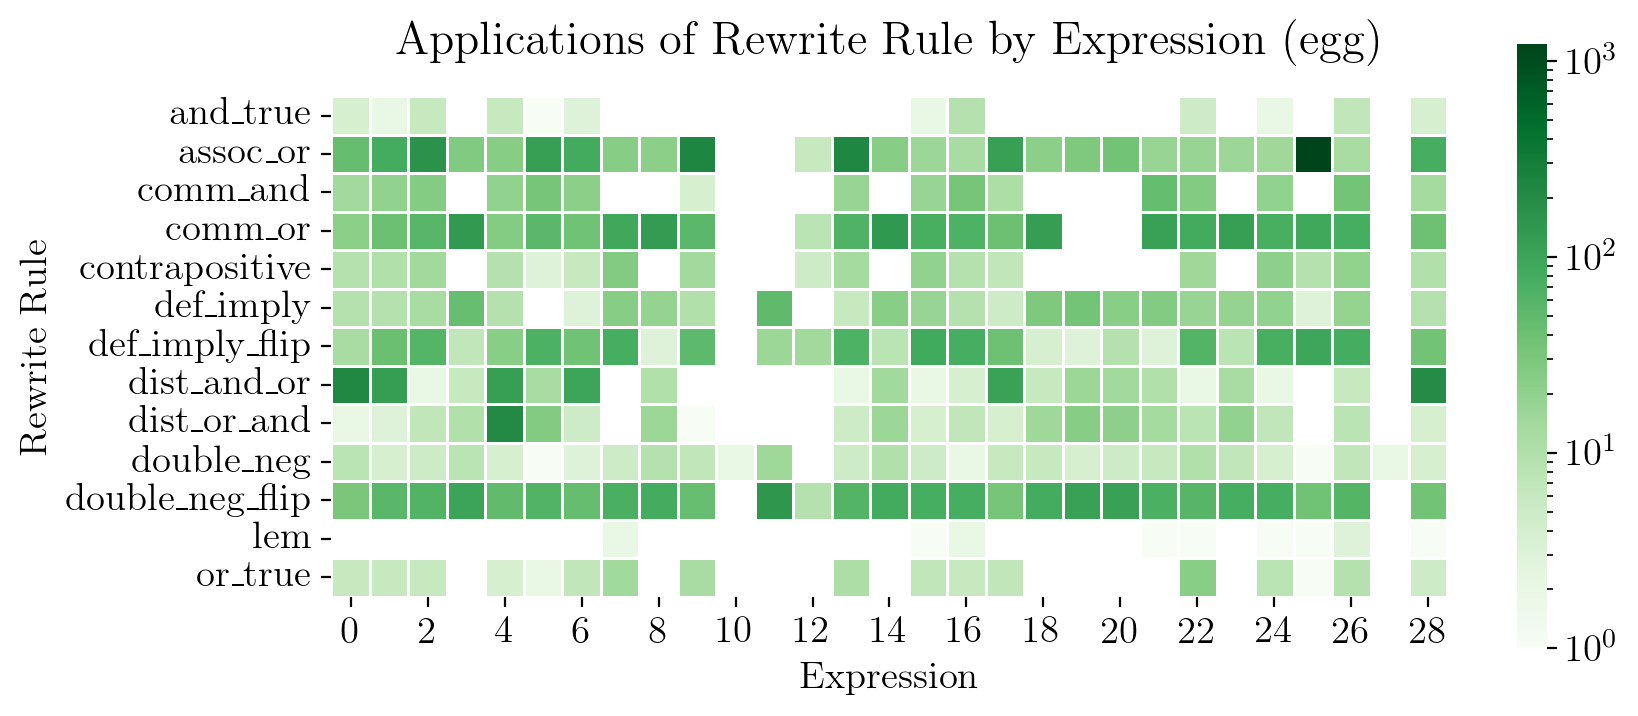

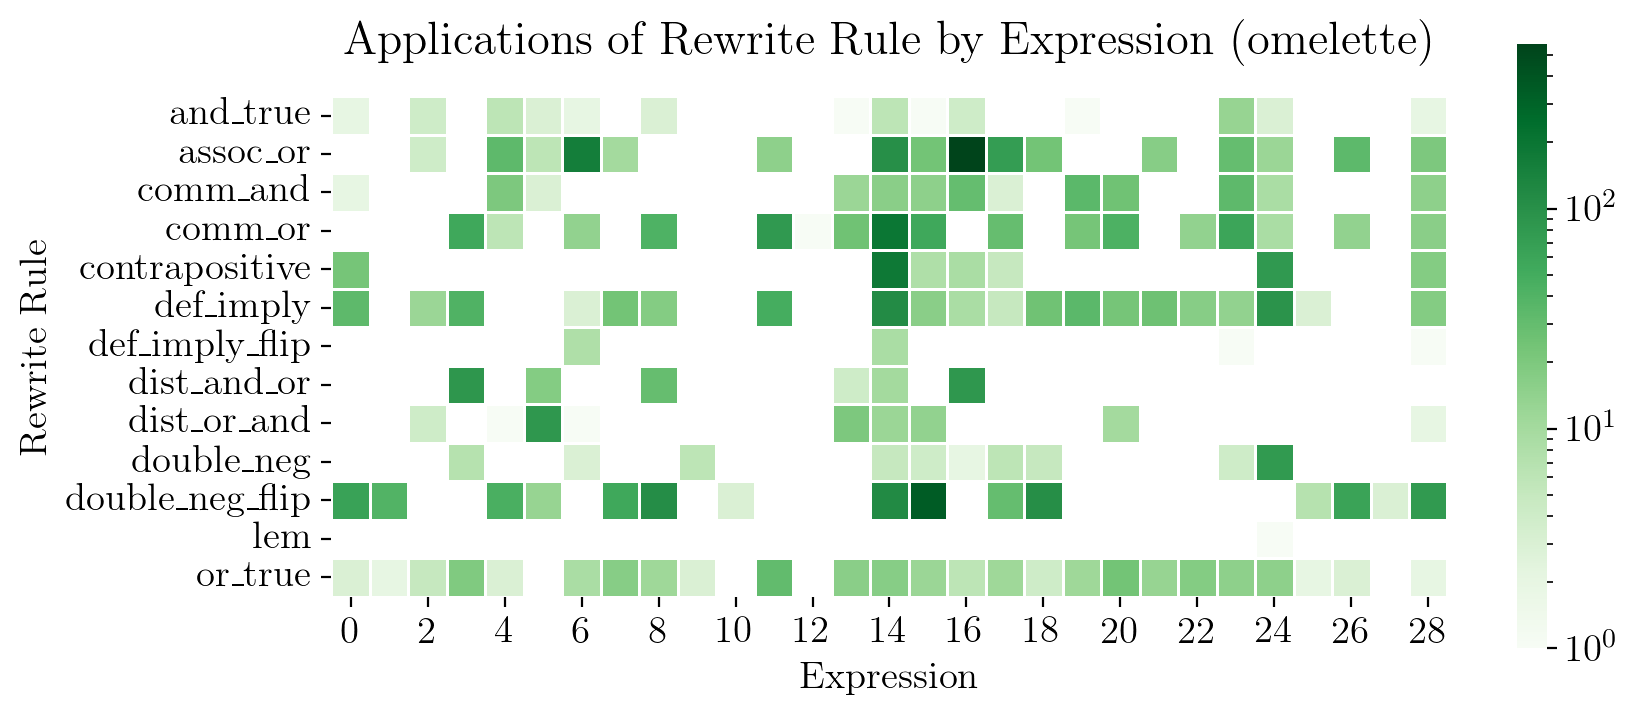

In [100]:
# Rule application heatmap
from matplotlib.colors import LogNorm, Normalize

df = load_data()
egg = df[df["solver"] == "egg"]
om = df[df["solver"] == "omelette"]

hm_egg = egg.groupby(["expr_ind", "action_name"])["num_applications"].sum().unstack(level=0, fill_value=0)
hm_egg = hm_egg.reindex(natsorted(hm_egg.columns), axis=1)

hm_om = om.groupby(["expr_ind", "action_name"])["num_applications"].sum().unstack(level=0, fill_value=0)
hm_om = hm_om.reindex(natsorted(hm_om.columns), axis=1)

def rule_app_hm(data, solver):
    plt.figure(figsize = (9,4))
    plt.rcParams['font.size'] = 14
    green = sns.color_palette("Greens", as_cmap=True).copy()
    green.set_under('white')
    g = sns.heatmap(data, cmap=green, square=True, linewidths=.5, vmin=1, vmax=1000, norm=LogNorm())
    g.set_title(f"Applications of Rewrite Rule by Expression ({solver})", pad=15, fontweight="bold")
    g.set(xlabel="Expression", ylabel="Rewrite Rule")
    g.get_figure().savefig(f"sync/rule_app_hm_{solver}.pdf", bbox_inches='tight')

rule_app_hm(hm_egg, "egg")
rule_app_hm(hm_om, "omelette")

In [60]:

def expr_summary():
    """Collapse each expression to a row summarizing it."""
    df = load_data()
    
    grouped = df.groupby(['expr_ind', 'solver']).agg({
        'step_ind': 'last',
        'stop_reason': 'last',
        'cost': 'last',
        'num_enodes': 'last',
        'num_eclasses': 'last',
        'training_time': 'last',
        'num_applications': 'sum',
    })
    grouped['training_time'] = grouped['training_time'] / 60_000 # convert to min
    grouped['step_ind'] = grouped['step_ind'] + 1 # convert index to step count
    grouped = grouped.rename(columns={'step_ind': 'num_actions'}).reset_index()
    grouped = grouped.pivot(index = "expr_ind", columns = "solver")
    grouped = grouped.sort_values(
        by=["expr_ind"],
        key=natsort_keygen()
    )
    grouped.cost = grouped.cost.astype(int)

    grouped = grouped.drop(columns=["stop_reason", "training_time", "num_eclasses"])
    grouped = grouped.rename(columns={'num_actions': "Actions", "num_enodes": "E-Nodes", "cost": "Cost", "num_applications": "Applications"})
    grouped = grouped.sort_index(axis=1)
    grouped["Cost", '\% Imp'] = round((grouped.Cost.egg - grouped.Cost.omelette) / grouped.Cost.egg * 100)
    grouped["Actions", '\% Imp'] = round((grouped["Actions"].egg - grouped["Actions"].omelette) / grouped["Actions"].egg * 100)
    grouped["Applications", '\% Imp'] = round((grouped["Applications"].egg - grouped["Applications"].omelette) / grouped["Applications"].egg * 100)
    grouped["E-Nodes", '\% Imp'] = round((grouped["E-Nodes"].egg - grouped["E-Nodes"].omelette) / grouped["E-Nodes"].egg * 100)
    grouped = grouped[["Cost", "Actions", "Applications", "E-Nodes"]] 
    grouped.index.names = ['Expr']
    return grouped

print(expr_summary())


       Cost                 Actions                 Applications           \
solver  egg omelette \% Imp     egg omelette \% Imp          egg omelette   
Expr                                                                        
0         6        4   33.0      19       23  -21.0          381      128   
1        36       65  -81.0      19        2   89.0          392       42   
2        39       55  -41.0      18        5   72.0          426       29   
3       182       68   63.0       8        8    0.0          338      208   
4        54       56   -4.0      20        9   55.0          499      115   
5        12       12    0.0      31       12   61.0          382      127   
6        36       17   53.0      19       10   47.0          348      201   
7        21       19   10.0      17        7   59.0          334      107   
8       165        1   99.0       8       10  -25.0          288      210   
9         3        7 -133.0      18        2   89.0          437        9   

In [7]:
def results_table():
    s = expr_summary().style.format(precision=0).to_latex(hrules=True, multicol_align="|c|", position_float="centering", position="ht", label="table:prop_single_res", caption="Results across the expressions in the PROP dataset. Omelette finds better solutions for 17 of the 29 tasks, performs the same for 5, and worse for 7.")

    with open("sync/cost_table.tex", "w") as text_file:
        text_file.write(s)

results_table()

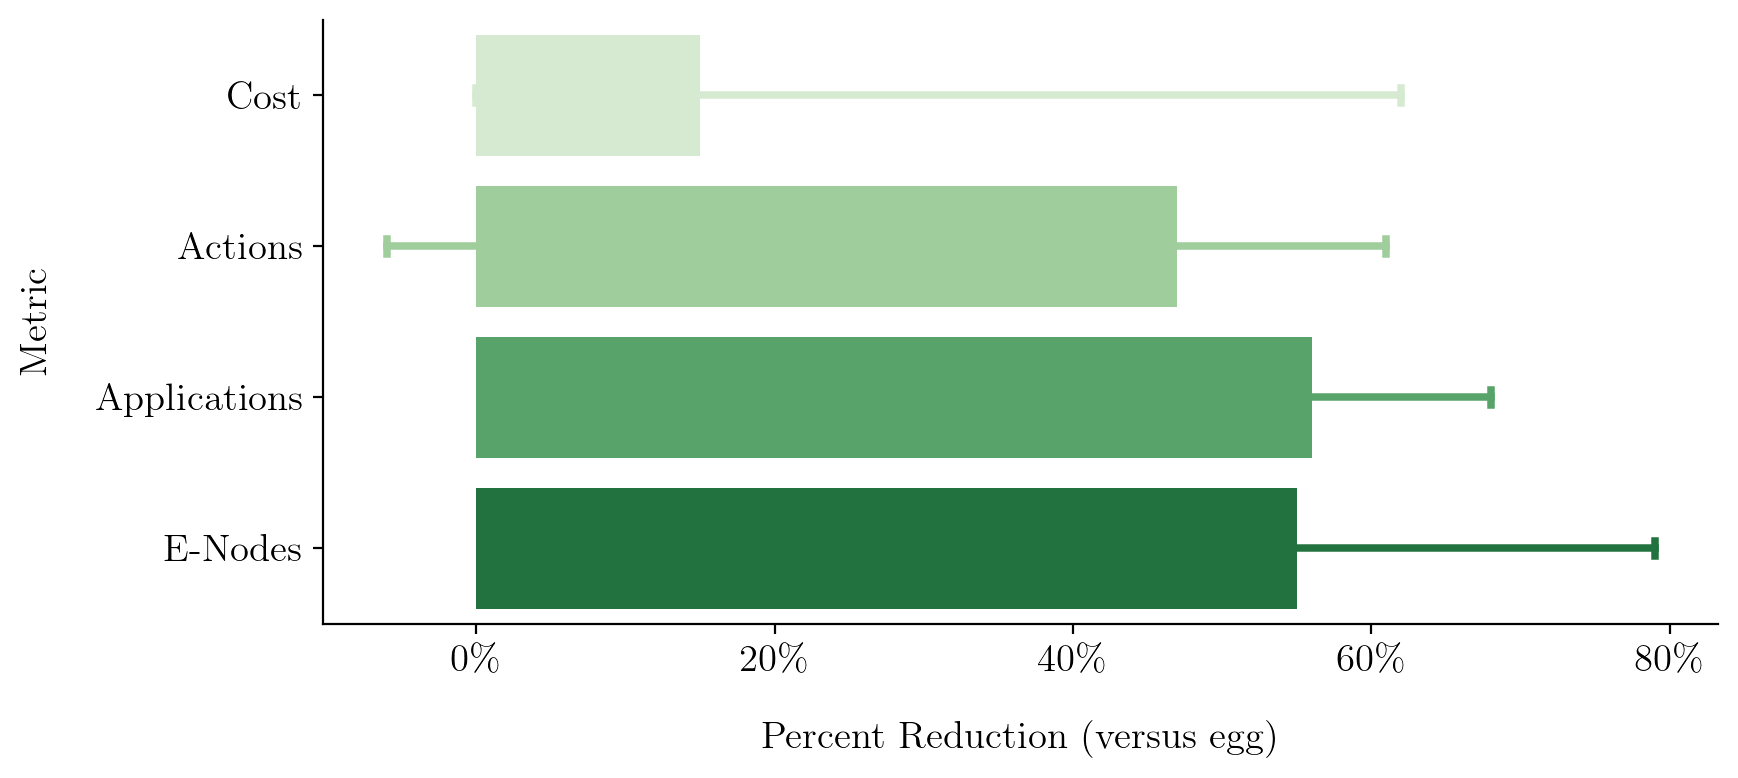

In [101]:
# Barplot for percent improvement across metrics

import matplotlib.ticker as mtick

df = expr_summary()
data = {"Cost": df["Cost", "\% Imp"],
        "Actions": df["Actions", "\% Imp"],
        "Applications": df["Applications", "\% Imp"],
        "E-Nodes": df["E-Nodes", "\% Imp"]}
df = pd.DataFrame(data).reset_index()
df = df.melt(["Expr"],  value_name="Percent Reduction (versus egg)", var_name="Metric")
plt.figure(figsize = (9,4))
ax = sns.barplot(data=df, y="Metric", x="Percent Reduction (versus egg)", palette="Greens", estimator=np.median, capsize=.1)
sns.despine(top=True, right=True)

patches = ax.patches
for i, line in enumerate(ax.get_lines()):
    newcolor = patches[i // 3].get_facecolor()
    line.set_color(newcolor)

ax.xaxis.labelpad = 15
ax.yaxis.labelpad = 15
plt.rcParams['font.size'] = 24
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.get_figure().savefig(f"sync/metric_summary_prop.pdf", bbox_inches='tight')

# Dataset Analysis

<AxesSubplot:title={'center':'Expression Breakdown by Operator Count'}, xlabel='Expression', ylabel='Operator'>

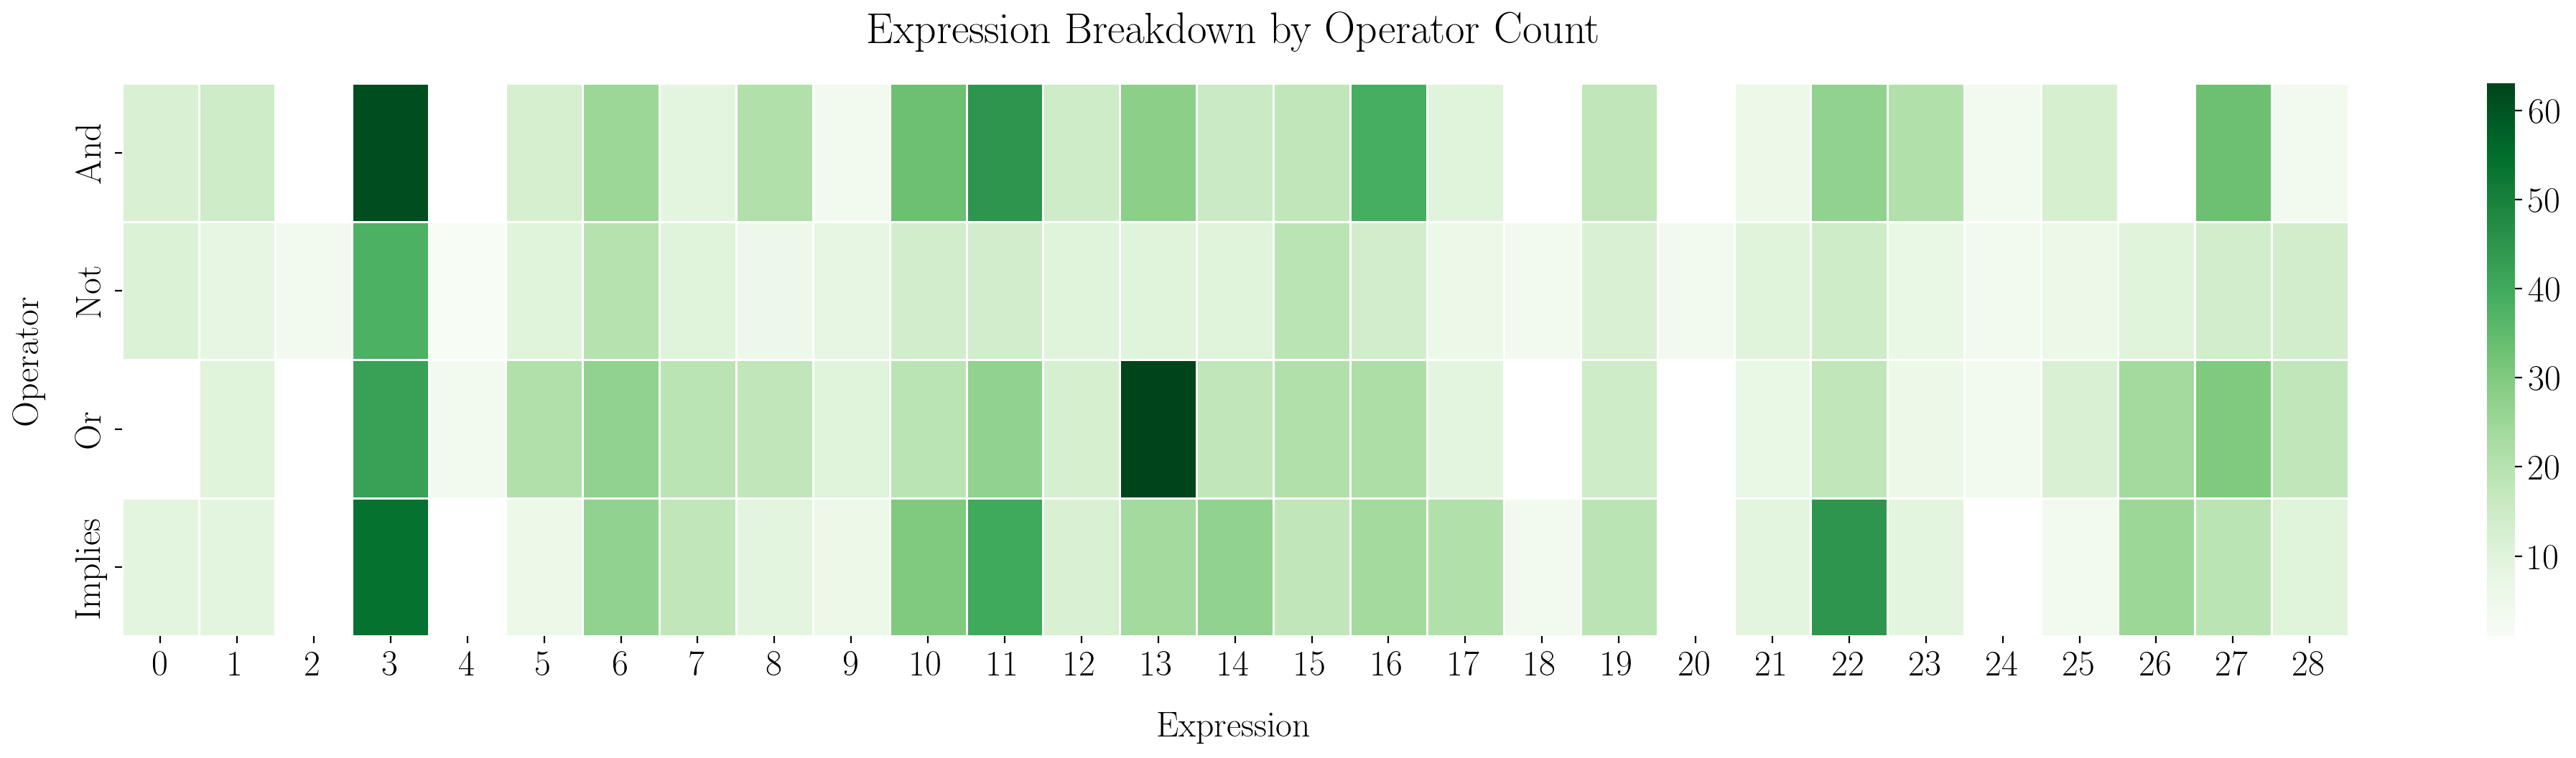

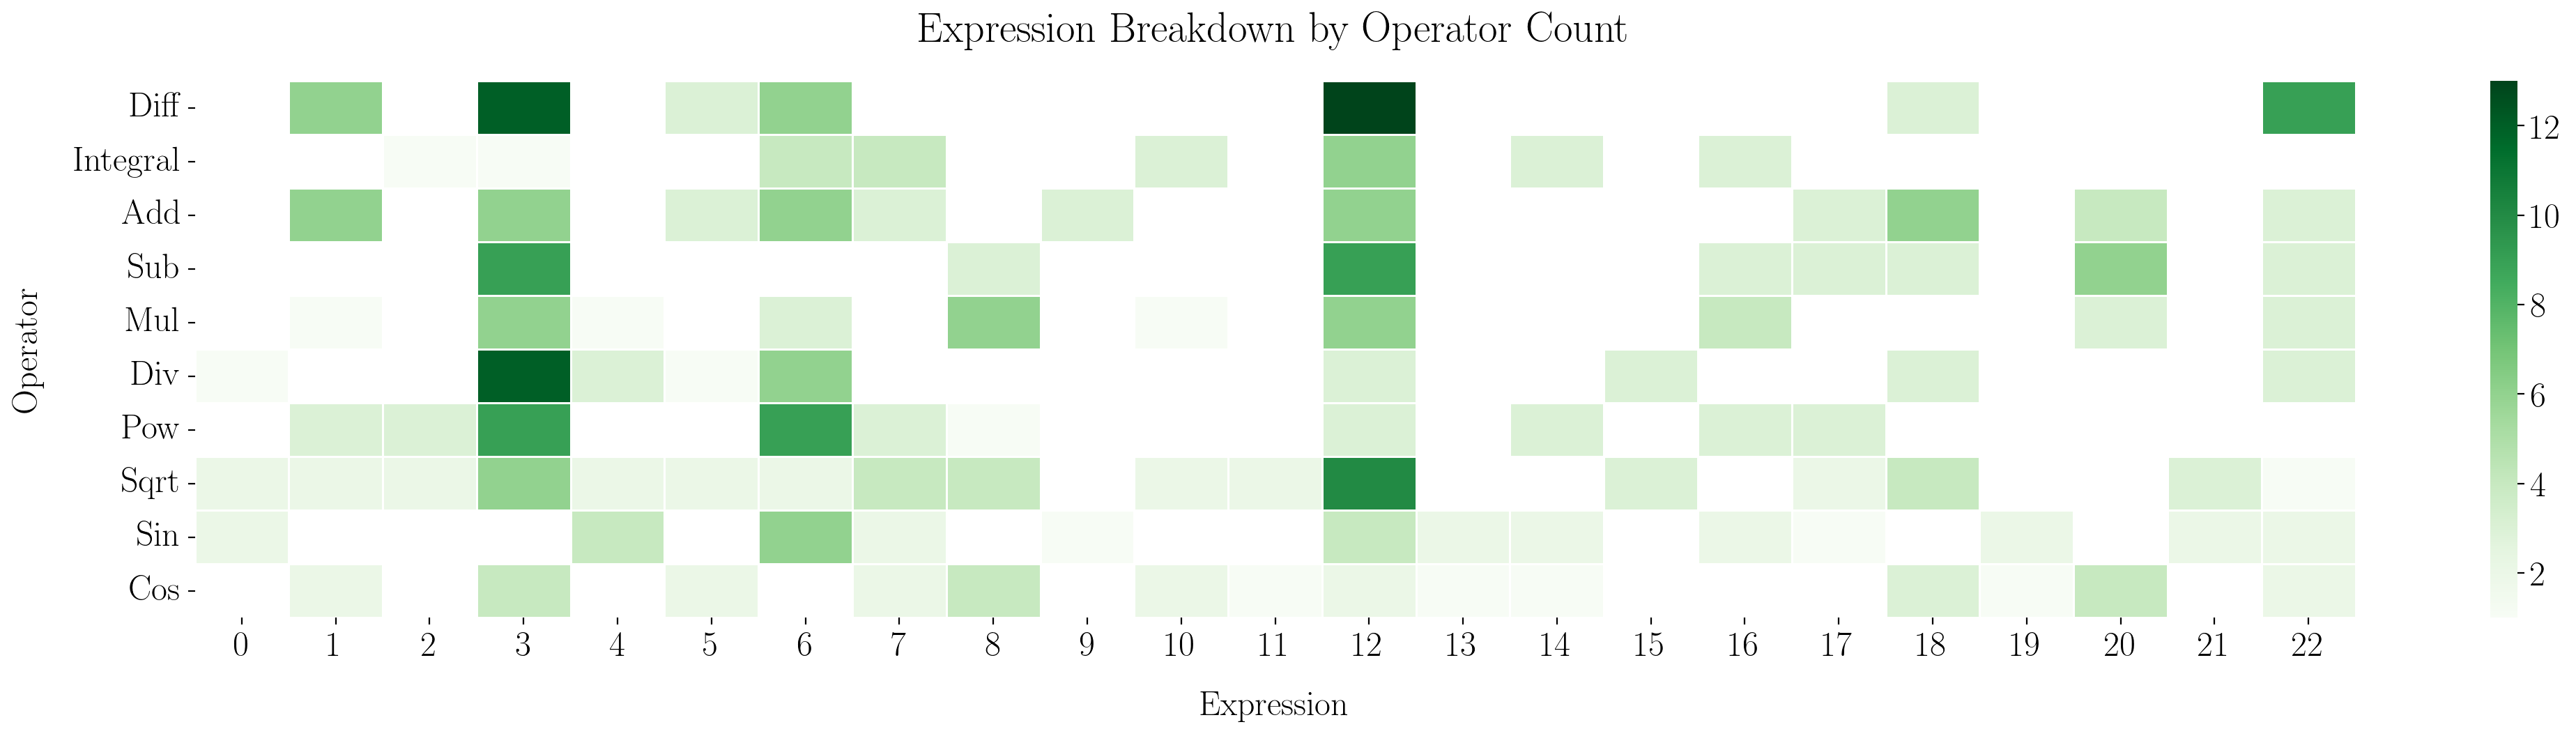

In [58]:
# Breakdown by node type

def dataset_breakdown(lang="PropLang", ax=None):
    df = load_data(lang=lang)
    operators = [s.capitalize() for s in (PropLang().operator_names() if lang == "PropLang" else MathLang().operator_names())]
    ind_to_expr = df.groupby(["expr_ind"])["init_expr"].first().reset_index(drop=True)
    e = ind_to_expr.apply(lambda x: x.replace("x=", "").replace("y=", ""))

    data_list = []
    for expr in e:
        op_counts = dict([(op, expr.count(op)) for op in operators])
        data_list.append(op_counts)


    df = pd.DataFrame(data_list).swapaxes("index", "columns")


    plt.figure(figsize = (25,5))

    green = sns.color_palette("Greens", as_cmap=True).copy()
    green.set_under('white')
    g = sns.heatmap(df, cmap=green, vmin=1, linewidths=.5, ax=ax)
    g.yaxis.labelpad = 15
    g.xaxis.labelpad = 15

    g.set_title(f"Expression Breakdown by Operator Count", pad=20, fontweight="bold")
    g.set(xlabel="Expression", ylabel="Operator")
    # g.get_figure().savefig(f"sync/{lang}_data_heatmap.pdf", bbox_inches='tight')
    return g

dataset_breakdown("PropLang")
dataset_breakdown("MathLang")

In [59]:
# Breakdown boxplots

# num_enodes in initial graph
# num_operators in initial graph
# cost of initial graph extraction
# hue'd by lang

def init_cost(lang, expr):
    expr = lang.eval_expr(expr)
    egraph = EGraph()
    egraph.add(expr)
    best_cost, _ = egraph.extract(expr)
    return best_cost

def num_enodes(lang, expr):
    expr = lang.eval_expr(expr)
    egraph = EGraph()
    egraph.add(expr)
    return egraph.total_size()

def get_dataset_boxplot_df(lang="PropLang"):
    df = load_data(lang=lang)
    lang = PropLang() if lang == 'PropLang' else MathLang()
    operators = [s.capitalize() for s in lang.operator_names()]
    df = df.groupby(["expr_ind"])["init_expr"].first().to_frame().reset_index()
    df["Operators"] = df.apply(lambda row: sum([row["init_expr"].count(op) for op in operators]), axis=1)
    df["Cost"] = df.apply(lambda row: init_cost(lang, row["init_expr"]), axis=1)
    df["E-Nodes"] = df.apply(lambda row: num_enodes(lang, row["init_expr"]), axis=1)
    return df



In [25]:
from matplotlib.gridspec import GridSpec

pdf = dataset_breakdown(lang="PropLang").drop(columns=["init_expr"])
# mdf = dataset_breakdown(lang="MathLang").drop(columns=["init_expr"])

fig = plt.figure()

gs = fig.add_gridspec(2, 3)
up_axes = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, :])

fig, axes = plt.subplots(2, ncols)

dataset_breakdown("PropLang", ax=ax3)

for ind, c in enumerate(["Operators", "Cost", "E-Nodes"]):


# Generalizability